In [1]:
!mamba install -y torchvision
!pip install torchvision==0.9.1 torch==1.8.1

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

/bin/bash: mamba: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.8.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.8.1 which is incompat

In [2]:
# Plot the data to check what a sample looks like
def show_data(data_sample):
  plt.imshow(data_sample[0].numpy().reshape(28,28), cmap='gray') # image

# Get training and test data

In [3]:
print('Getting training set...')
training_dataset = dsets.FashionMNIST('./data',train=True, download=True, transform=transforms.ToTensor())
print('Training set ready.')

print('Getting validation set...')
test_dataset = dsets.FashionMNIST('./data',train=False, download=True, transform=transforms.ToTensor())
print('Test set ready.')

Getting training set...


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!
Training set ready.
Getting validation set...
Test set ready.


/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Checking data

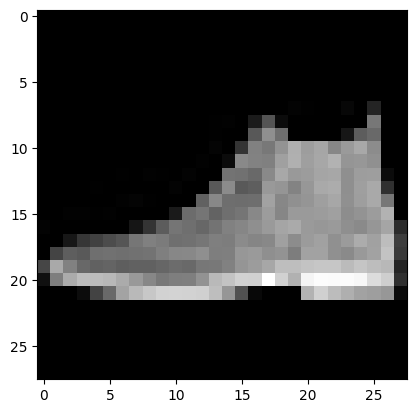

In [4]:
show_data(test_dataset[0])

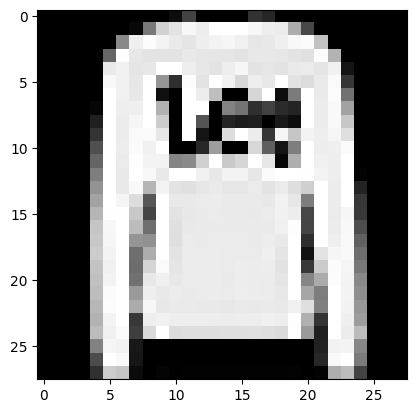

In [5]:
show_data(test_dataset[1])

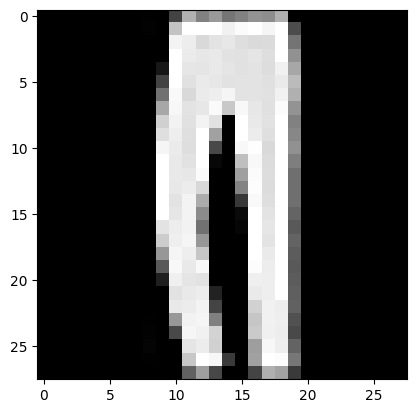

In [11]:
show_data(test_dataset[2])

In [38]:
print (f"Type of training_dataset: {type(training_dataset)}")
print (f"Size of training_dataset: {len(training_dataset)}")
print ("Num of elements in training_dataset: ", len(training_dataset))

print (f"Type of test_dataset: {type(test_dataset)}")
print (f"Size of test_dataset: {len(test_dataset)}")
print ("Num of elements in test_dataset: ", len(test_dataset))

Type of training_dataset: <class 'torchvision.datasets.mnist.FashionMNIST'>
Size of training_dataset: 60000
Num of elements in training_dataset:  60000
Type of test_dataset: <class 'torchvision.datasets.mnist.FashionMNIST'>
Size of test_dataset: 10000
Num of elements in test_dataset:  10000


In [39]:
# Prepare train and validation
indices = list(range(len(training_dataset)))
np.random.shuffle(indices)

# let's split 10% for validation as this is a large dataset
split = int(np.floor(len(training_dataset) * 0.9))

train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Put the data into dataloader
batch_size = 100
trainloader = torch.utils.data.DataLoader(training_dataset, batch_size = batch_size, sampler = train_sample)
validloader = torch.utils.data.DataLoader(training_dataset, batch_size = batch_size, sampler = valid_sample)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Building the Model

In [40]:
# Define input dimension and output dimensions

input_dim = 28 * 28 # image resolution
output_dim = 10 # 10 different classes

# Create a Softmax classifier for multi-class classification
class SoftMax(nn.Module):
  def __init__(self, input_size, output_size):
    super(SoftMax, self).__init__()

    # let's build 1 hidden layers and 1 output layer
    self.fc1 = nn.Linear(input_size, 100)
    self.fc2 = nn.Linear(100, output_dim)
    # We will dropout the neuron computations at 10%
    self.dropout = nn.Dropout(0.1)
    
  # Prediction
  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))

    # We will use log_softmax to get likelihood of all output classes
    x = F.log_softmax(self.fc2(x), dim=1)
    return x

# Training the Model

In [49]:
# instantiate the model
model = SoftMax(input_dim, output_dim)
print("Model: ", model)
print("Parameter w ", list(model.parameters())[0].size())
print("Parameter b ", list(model.parameters())[1].size())

# Set the hyperparameters
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss ()
n_epochs = 30

# We will store the params of the highest performing model
best_model_params = model.state_dict()

TRAIN_LOSS, VALID_LOSS = [], []
ACCURACY_LIST = []

def train_model(n_epochs):
  highest_accuracy = 0
  for epoch in range(n_epochs):
    trainloss = 0
    validloss = 0
    correct = 0

    for x, y in trainloader:
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
      trainloss += loss.item() * x.size(0)

    for x_test, y_test in validloader:
      z = model(x_test)
      loss = criterion(z, y_test)
      validloss += loss.item() * x_test.size(0)
    
    # average train and validation loss at each epoch
    trainloss = trainloss/len(trainloader.sampler)
    validloss = validloss/len(validloader.sampler)
    TRAIN_LOSS.append(trainloss)
    VALID_LOSS.append(validloss)

    # finding accuracy at test dataset
    for x_test, y_test in testloader:
      z = model(x_test)
      _, yhat = torch.max(z.data, 1)
      correct += (yhat == y_test).sum().item()
    accuracy = correct / len(testloader.sampler)
    
    # We want to keep the parameters of the highest performing model state
    if accuracy > highest_accuracy:
      best_model_params = model.state_dict()
      highest_accuracy = accuracy

    ACCURACY_LIST.append(accuracy)

    print ('Epoch: ', epoch,
           '\nTraining Loss: ', trainloss,
           '\nValidation Loss: ', validloss,
           '\nAccuracy: ', accuracy,
           '\n----------------------------------\n')

Model:  SoftMax(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Parameter w  torch.Size([100, 784])
Parameter b  torch.Size([100])


In [50]:
# Let's train the model
train_model(n_epochs)

Epoch:  0 
Training Loss:  0.8490258222376859 
Validation Loss:  0.6017919763922691 
Accuracy:  0.7879 
----------------------------------

Epoch:  1 
Training Loss:  0.5456530451774597 
Validation Loss:  0.5156898195544879 
Accuracy:  0.8161 
----------------------------------

Epoch:  2 
Training Loss:  0.4898672060282142 
Validation Loss:  0.49135483205318453 
Accuracy:  0.8233 
----------------------------------

Epoch:  3 
Training Loss:  0.4565021112561226 
Validation Loss:  0.4536168242494265 
Accuracy:  0.8336 
----------------------------------

Epoch:  4 
Training Loss:  0.43392632004839404 
Validation Loss:  0.44510239164034526 
Accuracy:  0.8379 
----------------------------------

Epoch:  5 
Training Loss:  0.41401643584723824 
Validation Loss:  0.42759049087762835 
Accuracy:  0.8455 
----------------------------------

Epoch:  6 
Training Loss:  0.3995281572971079 
Validation Loss:  0.42559201021989185 
Accuracy:  0.8396 
----------------------------------

Epoch:  7 
Tra

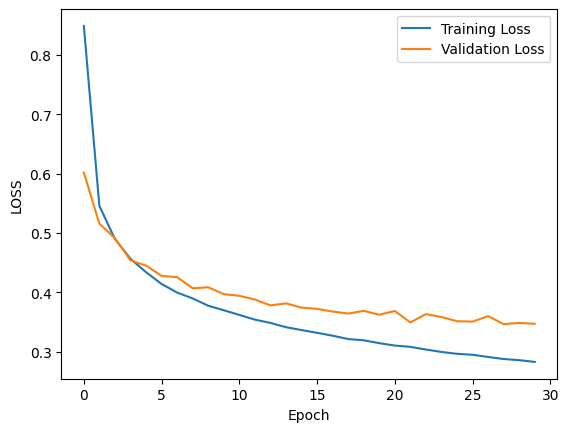

In [51]:
plt.plot(TRAIN_LOSS, label='Training Loss')
plt.plot(VALID_LOSS, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.show()

Final Test Accuracy:  87.12 %


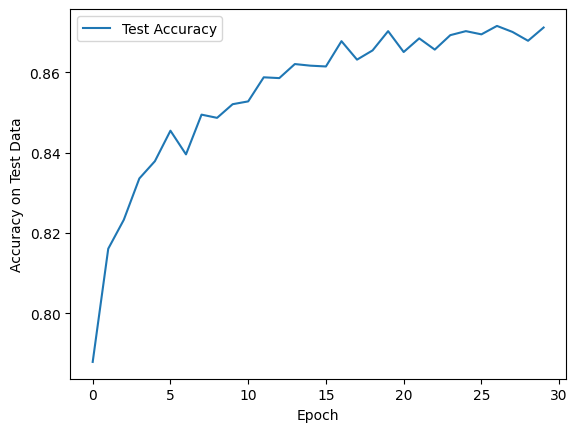

In [53]:
print ("Final Test Accuracy: ", ACCURACY_LIST[-1]*100,'%')
plt.plot(ACCURACY_LIST, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy on Test Data')
plt.legend()
plt.show()